In [10]:
from fluid import Fluid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.optimize import fsolve, minimize


co2 = Fluid('co2')

In [11]:

r_casing = (5.563 / 2.) * .0254 # m, https://en.wikipedia.org/wiki/List_of_thermal_conductivities
k_casing = 32.2 # [W/mK] 

r_concrete = (5 / 2.)  * .0254 
k_concrete = 0.8 

r_tube = (2.375 / 2.) * .0254
k_tube = 32.2

r_internal = (2 / 2.) * .0254 

k_fluid = .01224 #W/mK, https://www.engineeringtoolbox.com/carbon-dioxide-thermal-conductivity-temperature-pressure-d_2019.html
cp_fluid = .763  # kJ/kgK AT 225,  https://www.engineeringtoolbox.com/carbon-dioxide-d_974.html
pipe_e = 0.000015 # meters,  https://neutrium.net/fluid-flow/absolute-roughness-of-pipe-material/

def pipe_ctr(r_o, r_i, k, L): # https://www.engineersedge.com/heat_transfer/heat_loss_insulated_pipe_13865.htm
    return np.log(r_o/r_i)/(2*np.pi*k*L)

def total_pipe_ctr(r_casing, r_concrete, r_tube, k_casing, k_concrete, k_tube, L):
    tr_casing = pipe_ctr(r_casing, r_concrete, k_casing,L)
    tr_concrete = pipe_ctr(r_concrete, r_tube, k_concrete, L)
    tr_tube = pipe_ctr(r_tube, r_internal, k_tube, L)

    tr_tot = tr_casing + tr_concrete + tr_tube

    return tr_tot

tr_pipe = lambda length: total_pipe_ctr(r_casing, r_concrete, r_tube, k_casing, k_concrete, k_tube, length)

def darcy_friction_factor(Re, e_d):
    if Re < 2000:
        return 64/Re
    elif Re < 4000:
        return 0.316/Re**0.25
    else:
        return .0055*(1+((2*10**4)*(e_d) + 10**6/Re)**(1/3)) # 0.25/np.log10(e_d/3.7 + 5.74/Re**0.9)**2 # 

def darcy_law_pressure(p_a, v_dot, L, viscosity, permeability=10, A=2): # returns P_b output pressure
    p_b = p_a - (v_dot*viscosity*L)/(permeability*A)

    return p_b

def aquifer_heat_transfer(T_mi, rho, P, L, m_dot, T_s = 220+273, Nu=450):
    h = (Nu*k_fluid)/L
    cp_fluid = co2.cpmass(T=T_mi,D=rho)
    T_mo = T_s - np.exp((-P*L*h)/(m_dot*cp_fluid))*(T_s-T_mi)

    return T_mo

def head_loss(v, mu, l, d):
    Re = v*d/mu
    e_d = pipe_e / d
    f = darcy_friction_factor(Re, e_d)
    return f*l*v**2/(2*d*9.81)

Because of conservation of energy, the energy balance for a control volume can be written as:
$$
Q_{in}  = \dot m \big[ (h_2 - h_1) + \frac{1}{2}(v_2^2 - v_1^2) + g(z_2-z_1) + g h_l \big] 
$$

In [12]:
class State:
    def __init__(self,h,z,rho):
        self.h = h
        self.z = z
        self.rho = rho

In [24]:
triple_temp = co2.triple_temperature()
triple_pressure = co2.triple_pressure()

co2_triple_density = co2.density(T=triple_temp, P=triple_pressure)
print(co2_triple_density)

def solve_finite_element_method(mdot, state_in, length, T_external, radius, direction):
    v_in = mdot / (state_in.rho * np.pi * radius**2)
    h_l = head_loss(v_in,co2.viscosity(D=state_in.rho,H=state_in.h) , length,2*radius)
    T_in = co2.temperature(D=state_in.rho,H=state_in.h)
    q_in = tr_pipe(length) * (T_external - T_in) / mdot
    # mechanical energy
    p_in = co2.pressure(D = state_in.rho, H = state_in.h)
    me_lhs = p_in / state_in.rho + 0.5 * v_in**2 + 9.81 * state_in.z
    
    # thermal energy
    u1 = state_in.h - p_in / state_in.rho
    
    #if state_in.rho < co2_triple_density:
    #    raise ValueError('State is below the triple point')
    
    
    z_out = state_in.z - length if direction == 'down' else state_in.z + length
    def f(x):
        h_out,rho_out = x
        
        # find the 
        try:
            p_out = co2.pressure(D = rho_out, H = h_out)
        except:
            return np.Inf
        v_out = state_in.rho * v_in / rho_out
        u_out = h_out - p_out / rho_out
        me_loss = p_out / rho_out + 0.5 *(v_out)**2 + 9.81 * z_out - 9.81 * h_l - me_lhs
        heat_loss = u1 + q_in + 9.81 * h_l - u_out
        return me_loss**2 + heat_loss**2
    
    # solve for rho_out, h_out
    # assume Tout from cp
    cp = co2.cpmass(D=state_in.rho,H=state_in.h)
    Tout = co2.temperature(D=state_in.rho,H=state_in.h) + q_in / (mdot * cp)
    start_h = co2.enthalpy(D=state_in.rho, T=Tout)
    start_rho = state_in.rho
    h_out, rho_out  = minimize(f, [start_h,start_rho]).x
    
    return State(h_out, z_out, rho_out)

1178.4626431726008


In [25]:
pipe_length = 3.2e3
aquifer_length = 112
num_segments = 250
segment_length = pipe_length / num_segments
num_segments = int(num_segments)
surface_temp = 10 + 273 # C
temp_gradient = 62.5 # C/km
temp = lambda z: surface_temp - temp_gradient * z / 1e3


heights_down = np.linspace(0,-pipe_length,num_segments)
heights_up = np.linspace(-pipe_length,0,num_segments)
#combine the heights
total_height = np.concatenate((heights_down, heights_up))
enthalpies = np.zeros_like(total_height)
densities = np.zeros_like(total_height)

# plot the temperature profile
def calculate_pipe_properties(temp_in,pressure_in):
    state_in = State(h=co2.enthalpy(T=temp_in,P=pressure_in), z=0, rho=co2.density(T=temp_in,P=pressure_in))
    for i,h in tqdm(enumerate(heights_down), total=num_segments, desc="Descending"):
        state_out = solve_finite_element_method(3.2+10, state_in, segment_length, temp(h), r_internal,direction='down')
        enthalpies[i] = state_out.h
        densities[i] = state_out.rho
        #print(state_out.h, state_out.rho)
        state_in = state_out

    # find pressure drop and temperature gain through the aquifer:
    T_mi = co2.temperature(D=state_out.rho,H=state_out.h)
    P = co2.pressure(D=state_out.rho,H=state_out.h)
    vdot = 10 / state_out.rho

    #TODO: check that Ben implemented these correctly (i.e. what is L?)
    T_mo = aquifer_heat_transfer(T_mi, state_out.rho, P, aquifer_length, 10)
    P_out = darcy_law_pressure(P, 10, aquifer_length, co2.viscosity(D=state_out.rho,H=state_out.h))

    # reverse the heights
    state_in = State(h=co2.enthalpy(T=T_mo,P=P_out), z=-pipe_length, rho=co2.density(T=T_mo,P=P_out))
    for i,h in tqdm(enumerate(heights_up), total=num_segments, desc="Ascending"):
        state_out = solve_finite_element_method(10, state_in, 1* segment_length, temp(h), r_internal,direction='up')
        enthalpies[i+heights_down.shape[0]] = state_out.h
        densities[i+heights_down.shape[0]] = state_out.rho
        #print(state_out.h, state_out.rho)
        state_in = state_out
        
    temp_out = co2.temperature(D=state_out.rho,H=state_out.h)
    pressure_out = co2.pressure(D=state_out.rho,H=state_out.h)
    return temp_out, pressure_out

calculate_pipe_properties(312, 20e6)

Descending:   0%|          | 0/250 [00:00<?, ?it/s]

Ascending: 100%|██████████| 250/250 [00:01<00:00, 172.37it/s]


(535.6825534571349, 122834035.78842409)

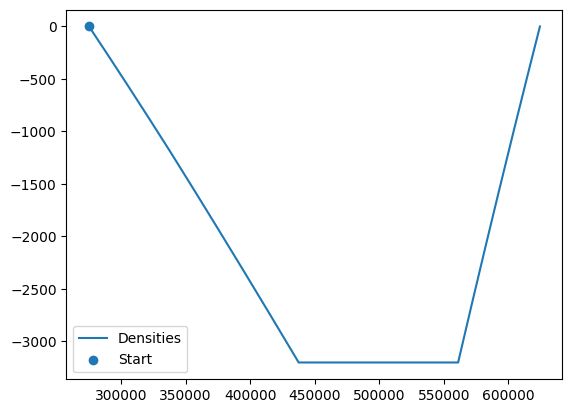

624462.8009481526 789.871273839302


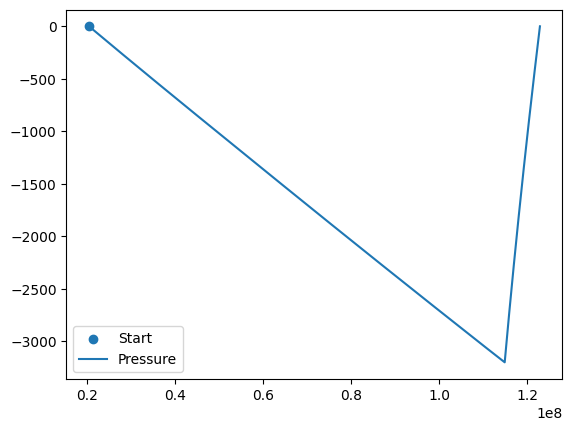

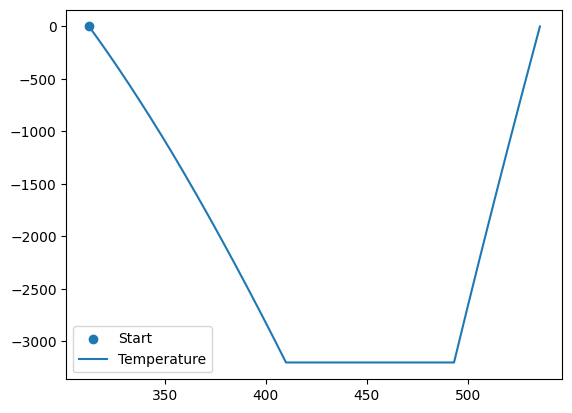

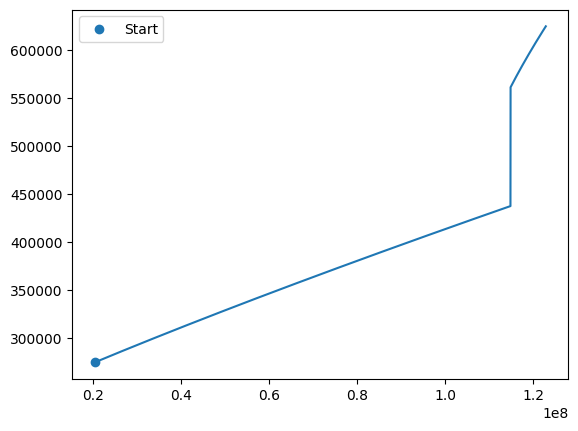

Temperature at the end of the pipe: 262.6825534571349 C
Pressure at the end of the pipe: 122.83403578842409 MPa


In [27]:
#plt.plot([temp(h) for h in heights],heights,label='Temperature')
plt.plot(enthalpies,total_height,label='Densities')
plt.scatter(enthalpies[0],total_height[0],label='Start')
#plt.plot(enthalpies,total_height,label='enthalpies')
plt.legend()
plt.show()
print(enthalpies[-1], densities[-1])
pressures = [co2.pressure(D=densities[i],H=enthalpies[i]) for i in range(len(densities))]
plt.scatter(pressures[0],total_height[0],label='Start')
plt.plot(pressures,total_height, label='Pressure')
plt.legend()
plt.show()

temperatures = [co2.temperature(D=densities[i],H=enthalpies[i]) for i in range(len(densities))]
plt.scatter(temperatures[0],total_height[0],label='Start')
plt.plot(temperatures,total_height,label="Temperature")
plt.legend()
plt.show()

#plot p-H diagram
plt.plot(pressures,enthalpies)
plt.scatter(pressures[0],enthalpies[0],label='Start')
plt.legend()
plt.show()

print(f"Temperature at the end of the pipe: {co2.temperature(D=densities[-1],H=enthalpies[-1])-273} C")
print(f"Pressure at the end of the pipe: {pressures[-1]/1e6} MPa")